# 1. Загрузка

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

DATA_DIR = Path("../data/human_poses_data")
IMG_TRAIN_DIR = DATA_DIR / "img_train"
IMG_TEST_DIR = DATA_DIR / "img_test"

train_df = pd.read_csv(DATA_DIR / "train_answers.csv")
categories_df = pd.read_csv(DATA_DIR / "activity_categories.csv")

print("train_answers.csv:")
display(train_df.head())
print(f"Размер: {train_df.shape}")

print("\nactivity_categories.csv:")
display(categories_df.head())
print(f"Размер: {categories_df.shape}")

train_answers.csv:


img_id  target_feature
0   17363               2
1    8612               5
2    8244               0
3    9264               0
4    5382               6

Размер: (12366, 2)

activity_categories.csv:


id                category
0   0                  sports
1   1  inactivity quiet/light
2   2           miscellaneous
3   3              occupation
4   4        water activities

Размер: (20, 2)


# 2. Анализ классов

In [2]:
print("Пропуски:")
print(train_df.isnull().sum())

print("\nКол-во уникальных классов в train:", train_df['target_feature'].nunique())
print("Все ли классы из categories присутствуют в train?",
      set(train_df['target_feature']).issubset(set(categories_df['id'])))

Пропуски:
img_id            0
target_feature    0
dtype: int64

Кол-во уникальных классов в train: 16
Все ли классы из categories присутствуют в train? True


/var/folders/lv/gvt68_m54_31k6x532fm6v800000gn/T/ipykernel_34957/1626727720.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=class_counts.index, x=class_counts.values, palette="viridis")


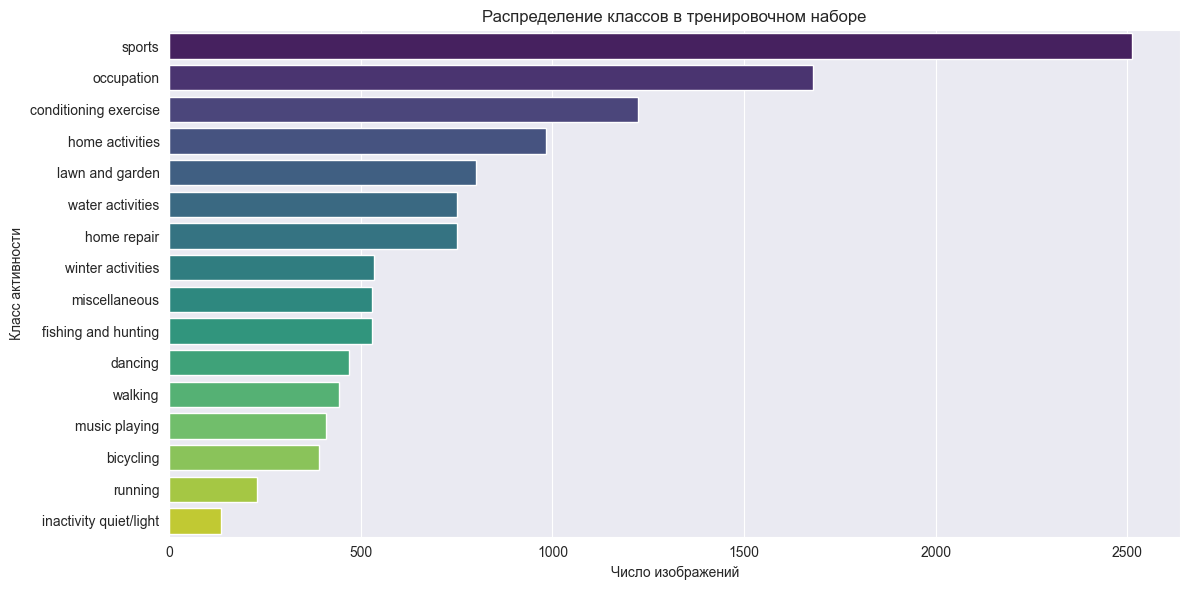

In [4]:
merged_df = train_df.merge(categories_df, left_on='target_feature', right_on='id')

class_counts = merged_df['category'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y=class_counts.index, x=class_counts.values, palette="viridis")
plt.title("Распределение классов в тренировочном наборе")
plt.xlabel("Число изображений")
plt.ylabel("Класс активности")
plt.tight_layout()
plt.show()

<span style="color:orange; font-weight: 900; font-size: 18px;">ахахах... их тут не 20</span>

In [5]:
all_categories = set(categories_df['id'])

used_categories = set(train_df['target_feature'])

unused_categories = all_categories - used_categories

print("Категории, не представленные в тренировочном наборе:")
display(categories_df[categories_df['id'].isin(unused_categories)])

Категории, не представленные в тренировочном наборе:


id              category
7    7  religious activities
15  15             self care
17  17  volunteer activities
19  19        transportation

# 3. Просмотр изображений

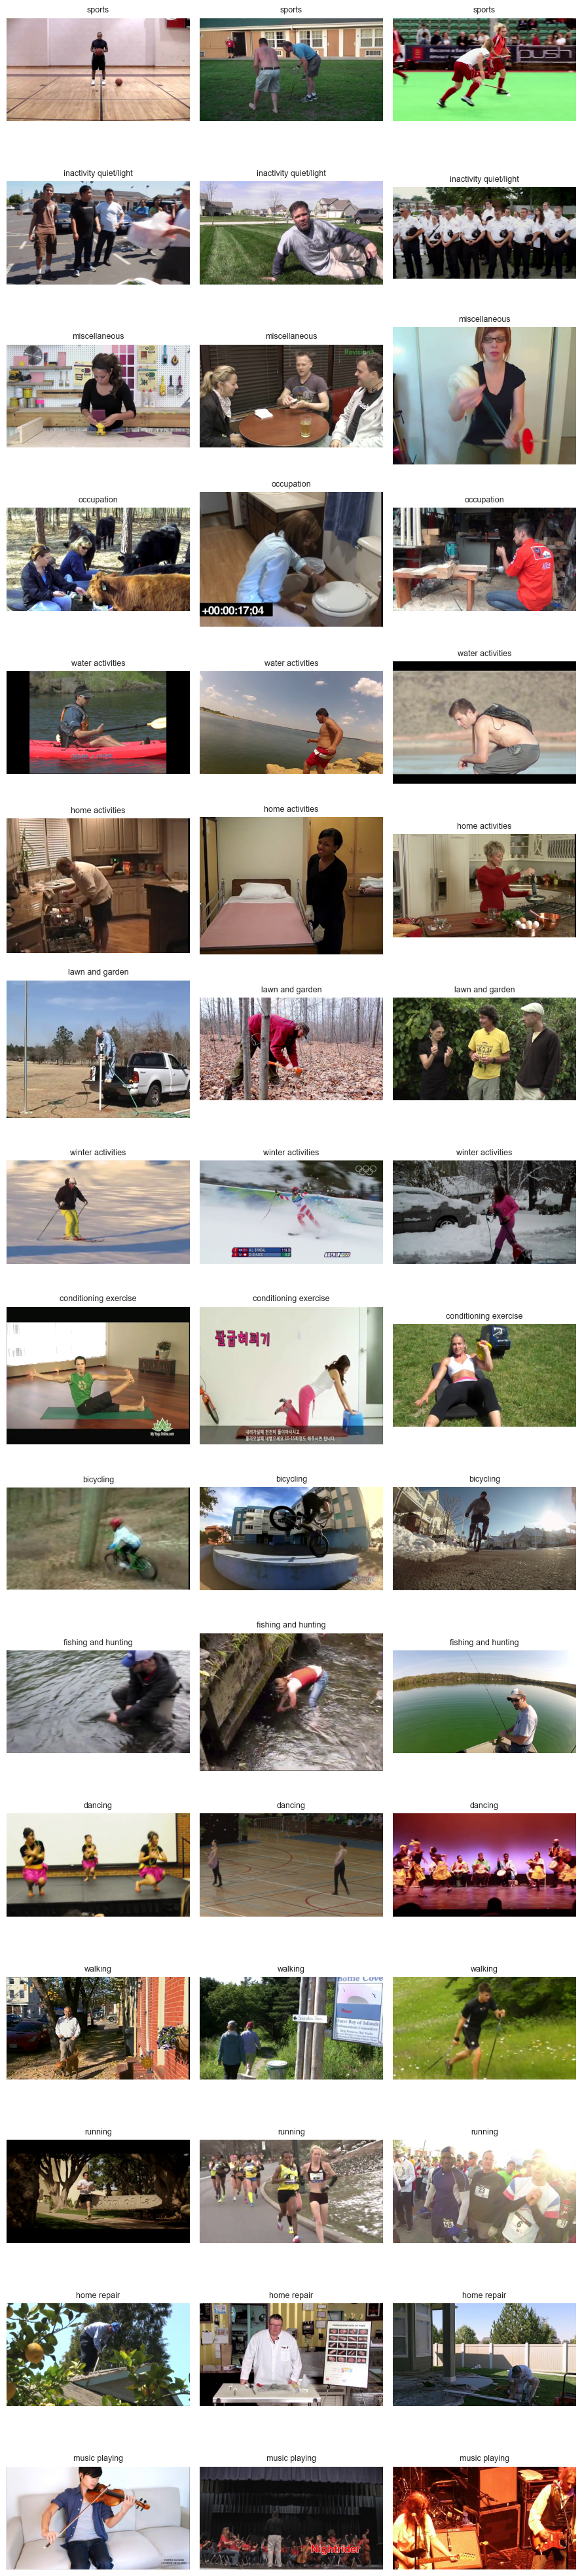

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

label_to_category = dict(zip(categories_df['id'], categories_df['category']))

samples_per_class = 3
selected = []

for label in sorted(train_df['target_feature'].unique()):
      subset = train_df[train_df['target_feature'] == label]
      chosen = subset.sample(samples_per_class, random_state=42)
      for _, row in chosen.iterrows():
            selected.append({
                  'img_path': IMG_TRAIN_DIR / f"{row['img_id']}.jpg",
                  'label': label,
                  'category': label_to_category[label]
            })

n_cols = samples_per_class
n_rows = len(set(row['label'] for row in selected))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

for idx, sample in enumerate(selected):
      row = idx // n_cols
      col = idx % n_cols
      ax = axes[row, col]
      image = Image.open(sample['img_path'])
      ax.imshow(image)
      ax.axis('off')
      ax.set_title(f"{sample['category']}", fontsize=9)

plt.tight_layout()
plt.show()

<span style="color:orange; font-weight: 900; font-size: 18px;">выводы: <br> </span>
<span style="color:orange; font-weight: 900; font-size: 18px;">количество человек не фиксированное(( <br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;"> разные ракурсы и крупность, модели нужно будет сохранять соотношение сторон<br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;"> разный цвет и освещение => brightness/contrast аугментации<br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;"> ООЧЕНЬ ПЛОХО ВСЕ С СООТНОШЕНИЕМ СТОРОН<br></span>

# 4. Соотношение сторон

In [11]:
all_img_paths = [IMG_TRAIN_DIR / f"{img_id}.jpg" for img_id in train_df['img_id']]

widths, heights = [], []

for path in all_img_paths:
      with Image.open(path) as img:
                  w, h = img.size
                  widths.append(w)
                  heights.append(h)

In [13]:
widths = np.array(widths)
heights = np.array(heights)
aspect_ratios = widths / heights

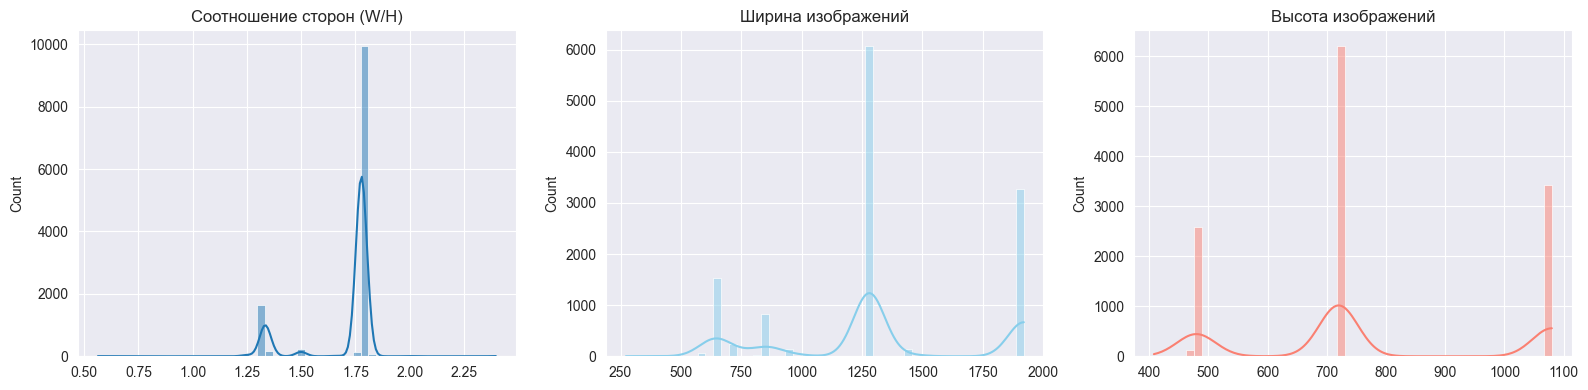

In [14]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
sns.histplot(aspect_ratios, bins=50, kde=True)
plt.title("Соотношение сторон (W/H)")

plt.subplot(1, 3, 2)
sns.histplot(widths, bins=50, kde=True, color="skyblue")
plt.title("Ширина изображений")

plt.subplot(1, 3, 3)
sns.histplot(heights, bins=50, kde=True, color="salmon")
plt.title("Высота изображений")

plt.tight_layout()
plt.show()


In [15]:
from collections import Counter

resolutions = list(zip(widths, heights))
res_counter = Counter(resolutions)
print("Топ 10 самых редких разрешений:")
for res, count in res_counter.most_common()[-10:]:
      print(f"{res}: {count} шт.")


Топ 10 самых редких разрешений:
(1266, 720): 3 шт.
(272, 480): 3 шт.
(900, 720): 2 шт.
(974, 720): 2 шт.
(768, 432): 2 шт.
(840, 480): 2 шт.
(1280, 716): 2 шт.
(1920, 960): 1 шт.
(806, 480): 1 шт.
(1920, 1072): 1 шт.


In [17]:
train_df['img_path'] = train_df['img_id'].apply(lambda x: IMG_TRAIN_DIR / f"{x}.jpg")

from collections import defaultdict

aspect_by_label = defaultdict(list)

for _, row in train_df.iterrows():
      try:
            with Image.open(row['img_path']) as img:
                  w, h = img.size
                  aspect_by_label[row['target_feature']].append(w / h)
      except:
            continue

label_avg_aspect = {
      label: np.mean(ratios) for label, ratios in aspect_by_label.items()
}

aspect_df = pd.DataFrame([
      (label, label_to_category[label], avg_ratio)
      for label, avg_ratio in label_avg_aspect.items()
], columns=["label", "category", "avg_aspect_ratio"])

aspect_df = aspect_df.sort_values(by="avg_aspect_ratio", ascending=False)
display(aspect_df)

label                category  avg_aspect_ratio
4      10               bicycling          1.755862
13      8       winter activities          1.750963
10     14                 running          1.749105
6       4        water activities          1.742491
15     12                 dancing          1.738614
2       0                  sports          1.732355
8      18           music playing          1.705586
14     11     fishing and hunting          1.703202
12     13                 walking          1.703165
9       1  inactivity quiet/light          1.701255
11     16             home repair          1.685581
7       3              occupation          1.684762
1       5         home activities          1.681854
5       9   conditioning exercise          1.681557
0       2           miscellaneous          1.674889
3       6         lawn and garden          1.627490

<span style="color:orange; font-weight: 900; font-size: 18px;">выводы: <br> </span>
<span style="color:orange; font-weight: 900; font-size: 18px;">у изображений огромный разброс по ширине и высоте от 272x480 до 1920x1072 <br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;"> некоторые оч редко встречаются, 1-2 раза<br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;"> у нас два пика соотношения сторон, но связь с классом не обнаружена, да и была бы она ликом скорее<br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;"> для стабильности надо приводить к 224x224 а как - хз, потом подумаю<br></span>

# 5. Качество изображений

In [19]:
import cv2
from PIL import ImageOps

sharpness_list = []
brightness_list = []
contrast_list = []

for path in all_img_paths:
      img = Image.open(path).convert("L")
      img_np = np.array(img)

      laplacian_var = cv2.Laplacian(img_np, cv2.CV_64F).var()
      sharpness_list.append(laplacian_var)

      brightness = img_np.mean()
      brightness_list.append(brightness)

      contrast = img_np.max() - img_np.min()
      contrast_list.append(contrast)

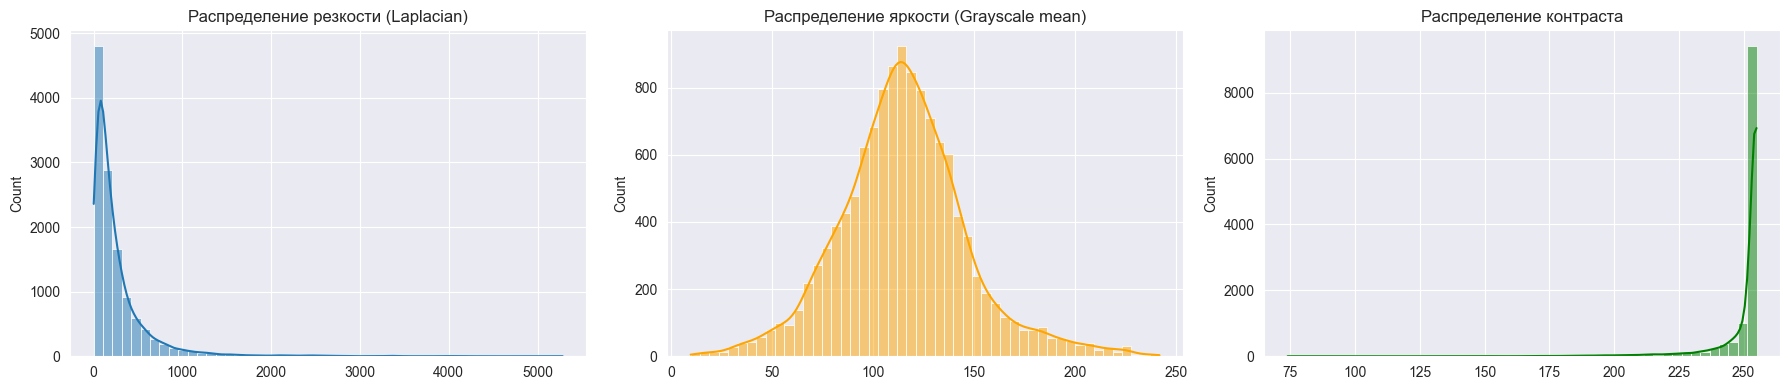

In [20]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
sns.histplot(sharpness_list, bins=50, kde=True)
plt.title("Распределение резкости (Laplacian)")

plt.subplot(1, 3, 2)
sns.histplot(brightness_list, bins=50, kde=True, color='orange')
plt.title("Распределение яркости (Grayscale mean)")

plt.subplot(1, 3, 3)
sns.histplot(contrast_list, bins=50, kde=True, color='green')
plt.title("Распределение контраста")

plt.tight_layout()
plt.show()

<span style="color:orange; font-weight: 900; font-size: 18px;">выводы: <br> </span>
<span style="color:orange; font-weight: 900; font-size: 18px;">много размытых оч(((( <br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;"> с яркостью и контрастом все нормально<br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;">можно удалять самые мыльные, ща посмотрим <br></span>

In [21]:
quality_df = pd.DataFrame({
      'img_path': all_img_paths,
      'sharpness': sharpness_list,
      'brightness': brightness_list,
      'contrast': contrast_list
})

worst_blurry = quality_df.sort_values(by='sharpness').head(12).reset_index(drop=True)

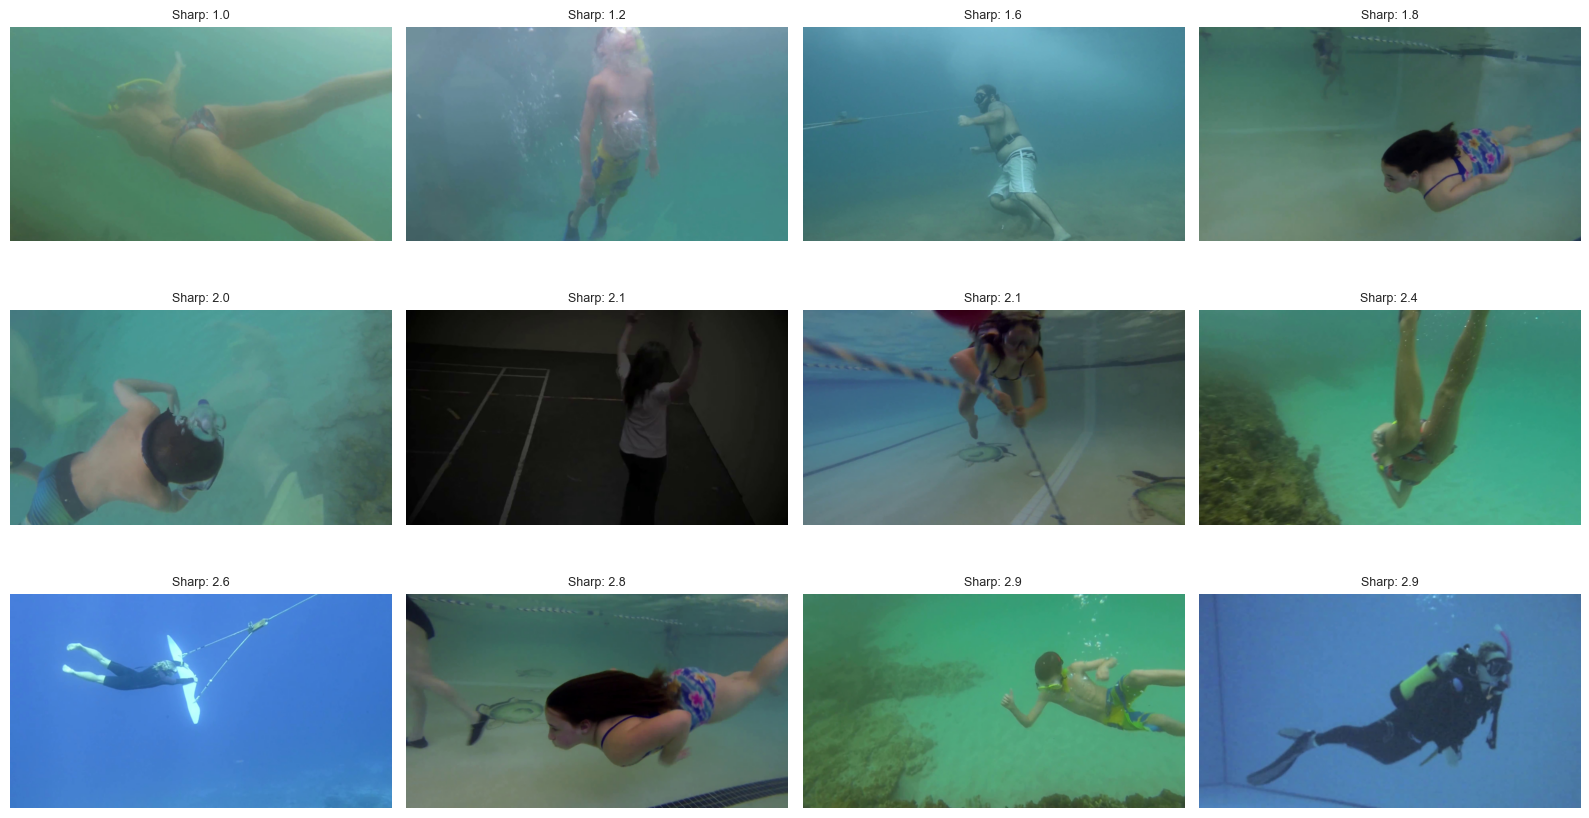

In [22]:
n_cols = 4
n_rows = int(np.ceil(len(worst_blurry) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))

for i, (idx, row) in enumerate(worst_blurry.iterrows()):
      ax = axes[i // n_cols, i % n_cols]
      img = Image.open(row['img_path'])
      ax.imshow(img)
      ax.axis('off')
      ax.set_title(f"Sharp: {row['sharpness']:.1f}", fontsize=9)
      
for j in range(i + 1, n_rows * n_cols):
      axes[j // n_cols, j % n_cols].axis("off")

plt.tight_layout()
plt.show()

<span style="color:orange; font-weight: 900; font-size: 18px;">ок удалять совсем нельзя <br> </span>

# 6. t-SNE, PCA

In [24]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm

from torchvision.transforms import ToTensor, Resize, Compose
transform = Compose([Resize((64, 64)), ToTensor()])

n_samples = 2000
subset = train_df.sample(n_samples, random_state=42).reset_index(drop=True)

images = []
labels = []

for _, row in tqdm(subset.iterrows(), total=n_samples):
      img = Image.open(IMG_TRAIN_DIR / f"{row['img_id']}.jpg").convert('RGB')
      img = transform(img)
      images.append(img.view(-1).numpy())
      labels.append(row['target_feature'])


X = np.stack(images)
y = np.array(labels)


100%|██████████| 2000/2000 [00:19<00:00, 101.45it/s]


In [25]:
X_pca = PCA(n_components=50, random_state=42).fit_transform(X)

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_pca)

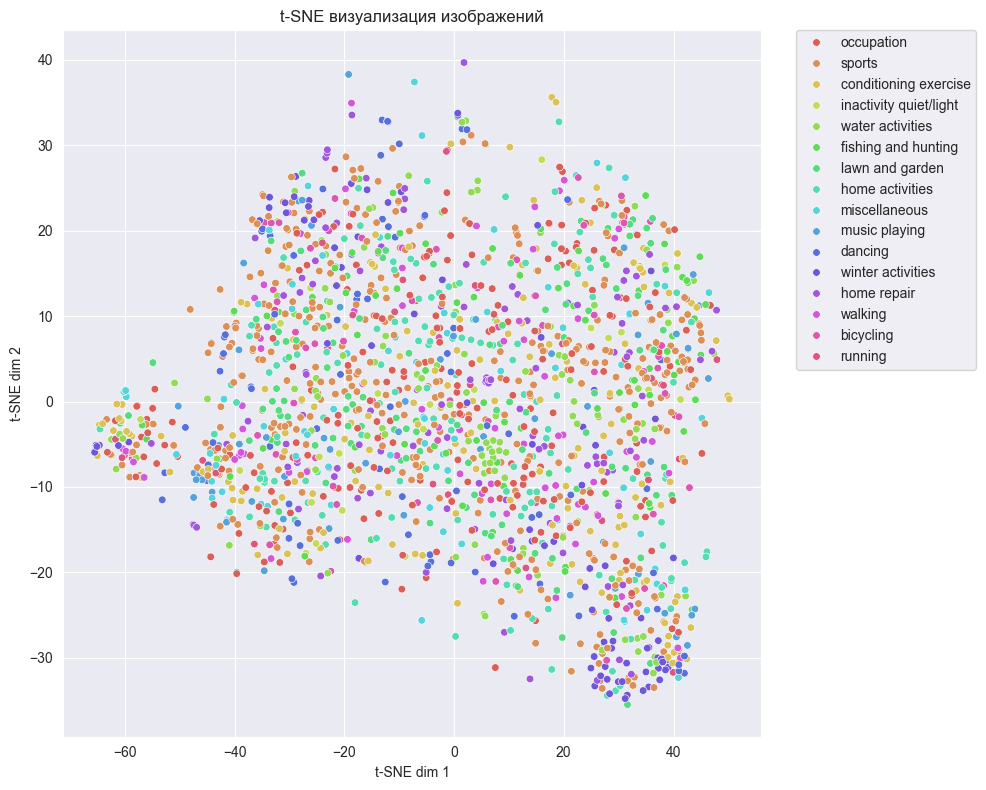

In [27]:
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hls", len(set(y)))

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=[label_to_category[i] for i in y],
                palette=palette, legend='full', s=30)

plt.title("t-SNE визуализация изображений")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.savefig('t-SNE.png')
plt.show()

<span style="color:orange; font-weight: 900; font-size: 18px;">выводы: <br> </span>
<span style="color:orange; font-weight: 900; font-size: 18px;">эхххх ну видимо легко не будет<br></span>
<span style="color:orange; font-weight: 900; font-size: 18px;"> возможен выигрыш от self-supervised если мне разрешат<br></span>